# Imports

Import needed libraries

In [2]:
from scipy.io import loadmat
from pandas import factorize
import pickle
from flask import Flask, request, render_template
from pyngrok import ngrok
import numpy as np
import random

import os
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Mount to Google Drive (optional)

In [90]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/MyDrive/"

Mounted at /content/gdrive


# Defined functions for easier work with data

## Functions to load datasets

In [3]:
def load_dataset(dataset_location):
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset_location.keys())))), [1,0])
    snrs = snrs[10:]
    X = []; I = []; Q = []; lbl = [];

    for mod in mods:
        for snr in snrs:
            X.append(dataset_location[(mod,snr)])
            for i in range(dataset_location[(mod,snr)].shape[0]):
                lbl.append((mod,snr))
    X = np.vstack(X); lbl=np.vstack(lbl)

    X = np.transpose(X[:,:,:],(0,2,1))

    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)



    return snrs, X, mods, one_hot_encode, lbl_SNR

## Functions to handle the datasets

In [4]:
def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15, seed = 42):

    # Set random seed
    np.random.seed(seed)
    random.seed(seed)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)

    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))

    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)

    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)

    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test



In [29]:
def return_indices_of_a(a, b):
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

In [5]:
def normalize_data(X_train, X_valid, X_test):
    # mean-std normalization

    mean = X_train[:,:,:].mean(axis=0)
    X_train[:,:,:] -= mean
    std = X_train[:,:,:].std(axis=0)
    X_train[:,:,:] /= std


    X_valid[:,:,:] -= mean
    X_valid[:,:,:] /= std

    X_test[:,:,:] -= mean
    X_test[:,:,:] /= std

    return X_train, X_valid, X_test

## Functions for plotting

In [6]:
def show_confusion_matrix(validations, predictions, matrix_snr, save=False):

    cm = confusion_matrix(validations, predictions)
    # Normalise
    base_dir = './'
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=mods, yticklabels=mods)
    sns.set(font_scale=1.3)
    if matrix_snr == None:
        plt.title("Confusion Matrix")
    else:
        plt.title("Confusion Matrix \n" + str(matrix_snr) + "dB")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    print(os.listdir())
    if save == True:
        plt.savefig(str(matrix_snr) + '.png')
    plt.show(block=False)


In [7]:
def All_SNR_show_confusion_matrix(X_test, save=False):
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Pred, Y_Test, 'Overall', save)

In [8]:
def SNR_show_confusion_matrix(in_snr, lbl_SNR, X_test, save=False):

    for snr in in_snr:
        matrix_snr = snr
        m_snr = matrix_snr;

        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = [];
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(lbl_SNR)):
            if int(lbl_SNR[i]) == m_snr:
                matrix_snr_index.append(i)

        indeces_of_Y_test = return_indices_of_a(test_idx, matrix_snr_index)

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])
        show_confusion_matrix(Y_Pred_SNR, Y_Test_SNR, matrix_snr, save)

In [9]:
def SNR_show_confusion_matrix_new(in_snr, lbl_SNR, X_test, save):
    Y_Pred = model.predict(X_test)
    print(Y_Pred)
    # Ensure lbl_SNR contains values from 0 to 10
    lbl_SNR = np.clip(lbl_SNR, 0, 10) # Clip values to be within the valid range
    Y_Test = to_categorical(lbl_SNR, num_classes = 11)
    print(Y_Test)
    Y_Pred_SNR = []
    Y_Test_SNR = []
    min_len = min(len(in_snr), len(lbl_SNR))
    matrix_snr = []
    for i in range(min_len): # Use min_len to avoid index out of range
        if (in_snr[i] == lbl_SNR[i]):
            matrix_snr.append(lbl_SNR[i])
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])
    print(f'Y_Pred_SNR: {Y_Pred_SNR}') # Check the contents of Y_Pred_SNR
    print(f'Y_Test_SNR: {Y_Test_SNR}') # Check the contents of Y_Test_SNR
    show_confusion_matrix_new(Y_Pred_SNR, Y_Test_SNR, matrix_snr, save)

def show_confusion_matrix_new(validations, predictions, matrix_snr, save):
    matrix = metrics.confusion_matrix(validations, predictions)
    # plt.figure(figsize=(15, 15))
    # sns.heatmap(matrix,
    #             cmap='coolwarm',
    #             linecolor='white',
    #             linewidths=1,
    #             xticklabels=mods,
    #             yticklabels=mods,
    #             annot=True,
    #             fmt='d')
    # plt.title('Confusion Matrix')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # if save == True:
    #     plt.savefig('confusion_matrix.png')

    cm = confusion_matrix(validations, predictions)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mods).plot()
    plt.show()
    # print(f'cm: {cm}') # Check the contents of cm
    # cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # fig, ax = plt.subplots(figsize=(10,10))
    # # sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=mods, yticklabels=mods)
    # sns.set(font_scale=1.3)
    # if matrix_snr == None:
    #     plt.title("Confusion Matrix")
    # else:
    #     a = np.mean(matrix_snr)
    #     a = int(a)
    #     plt.title("Confusion Matrix for SNR = "+str(a)+" dB")
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.show()

In [10]:
def plot_split_distribution(mods, Y_train, Y_valid, Y_test):

    x = np.arange(len(mods))  # the label locations
    width = 1  # the width of the bars

    fig, ax = plt.subplots()
    bar1 = ax.bar(x-width*0.3, np.count_nonzero(Y_train == 1, axis=0), width*0.3, label = "Train" )
    bar2 = ax.bar(x , np.count_nonzero(Y_valid == 1, axis=0), width*0.3, label = "Valid" )
    bar3 = ax.bar(x+width*0.3, np.count_nonzero(Y_test == 1, axis=0), width*0.3, label = "Test" )


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Distribution')
    ax.set_title('Distribution overview of splitted dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(mods)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)


In [ ]:
def SNR_accuracy(in_snr, name):
    """
    Computes accuracies of chosen SNRs individualy

    in_snr:   must be list of SNRs
    """

    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(SNR, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 19, 2 )
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10 )
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-20, 18)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
    plt.xticks(rotation=90)
    # plt.savefig(base_dir + name + '.png')
    plt.show()

    return acc[:,1]


# Access the datasets



In [13]:
root_dir = ''

In [14]:
dataset_pkl = open(root_dir+'RML2016.10a_dict.pkl','rb')
RML_dataset_location = pickle.load(dataset_pkl, encoding='bytes')

# Load the data

## DeepSig Dataset

In [15]:
# 10a
SNR, X, modulations, one_hot, lbl_SNR = load_dataset(RML_dataset_location)


In [16]:
mods = []
for i in range(len(modulations)):
    modu = modulations[i].decode('utf-8')
    mods.append(modu)

In [17]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15, seed=102)
flask_x_test = X_test
flask_y_test = Y_test

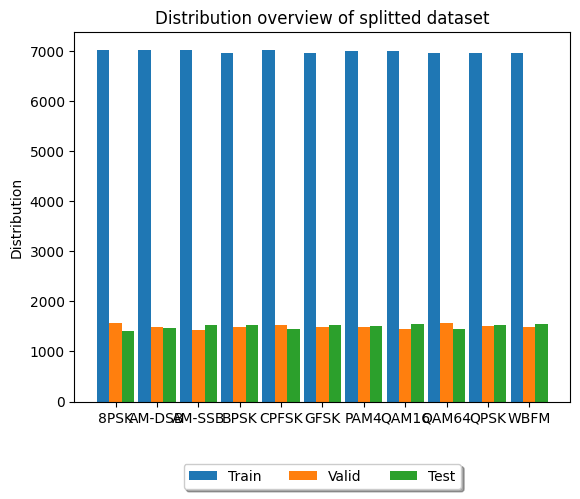

In [18]:
plot_split_distribution(mods, Y_train, Y_valid, Y_test)

In [19]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

# Architectures for training

## CLDNN

In [22]:
layer_in = keras.layers.Input(shape=(128,2))
layer = keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu')(layer_in)
layer = keras.layers.MaxPool1D(pool_size=2)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.GRU(40, return_sequences=True)(layer)
layer = keras.layers.GaussianDropout(0.4)(layer)
layer = keras.layers.Flatten()(layer)
layer_out = keras.layers.Dense(len(mods), activation='softmax')(layer)

model = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.0007)

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "cldnn_model.keras", save_best_only=True, monitor="val_loss"),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.4, patience=5, min_lr=0.000007),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, verbose=1)]

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 121, 64)        │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 40)         │        12,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_dropout_1              │ (None, 60, 40)         │             0 │
│ (GaussianDropout)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │        26,411 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,267 (415.11 KB)

 Trainable params: 106,267 (415.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.backend.clear_session()
history = model.fit(X_train, Y_train, batch_size=128, epochs=30, verbose=2, validation_data= (X_valid, Y_valid))


Epoch 1/30
602/602 - 9s - 15ms/step - accuracy: 0.8218 - loss: 0.3308 - val_accuracy: 0.8286 - val_loss: 0.3034
Epoch 2/30
602/602 - 10s - 17ms/step - accuracy: 0.8263 - loss: 0.3209 - val_accuracy: 0.8368 - val_loss: 0.2962
Epoch 3/30
602/602 - 9s - 15ms/step - accuracy: 0.8308 - loss: 0.3131 - val_accuracy: 0.8405 - val_loss: 0.3054
Epoch 4/30
602/602 - 11s - 18ms/step - accuracy: 0.8364 - loss: 0.3049 - val_accuracy: 0.8307 - val_loss: 0.3012
Epoch 5/30
602/602 - 10s - 17ms/step - accuracy: 0.8413 - loss: 0.2950 - val_accuracy: 0.8544 - val_loss: 0.2766
Epoch 6/30
602/602 - 11s - 18ms/step - accuracy: 0.8442 - loss: 0.2912 - val_accuracy: 0.8421 - val_loss: 0.2885
Epoch 7/30
602/602 - 9s - 16ms/step - accuracy: 0.8506 - loss: 0.2840 - val_accuracy: 0.8576 - val_loss: 0.2671
Epoch 8/30
602/602 - 10s - 16ms/step - accuracy: 0.8555 - loss: 0.2783 - val_accuracy: 0.8625 - val_loss: 0.2698
Epoch 9/30
602/602 - 10s - 17ms/step - accuracy: 0.8608 - loss: 0.2701 - val_accuracy: 0.8710 - val

In [ ]:
model.save("cldnn_model.keras")

In [24]:
model = keras.models.load_model("cldnn_model_gru.keras")
test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9199 - loss: 0.1739
Test accuracy 0.9194545745849609
Test loss 0.17795579135417938



SNR 0dB:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=('*',)
  warnings.warn(


51/51 - 1s - 14ms/step - accuracy: 0.9121 - loss: 0.2187

SNR 2dB:
52/52 - 0s - 9ms/step - accuracy: 0.9252 - loss: 0.1633

SNR 4dB:
53/53 - 0s - 9ms/step - accuracy: 0.9281 - loss: 0.1539

SNR 6dB:
50/50 - 0s - 9ms/step - accuracy: 0.9114 - loss: 0.1766

SNR 8dB:
54/54 - 0s - 9ms/step - accuracy: 0.9297 - loss: 0.1790

SNR 10dB:
52/52 - 0s - 9ms/step - accuracy: 0.9239 - loss: 0.1711

SNR 12dB:
53/53 - 0s - 9ms/step - accuracy: 0.9130 - loss: 0.1971

SNR 14dB:
52/52 - 0s - 9ms/step - accuracy: 0.9228 - loss: 0.1744

SNR 16dB:
50/50 - 0s - 10ms/step - accuracy: 0.9181 - loss: 0.1745

SNR 18dB:
51/51 - 0s - 9ms/step - accuracy: 0.9093 - loss: 0.1716


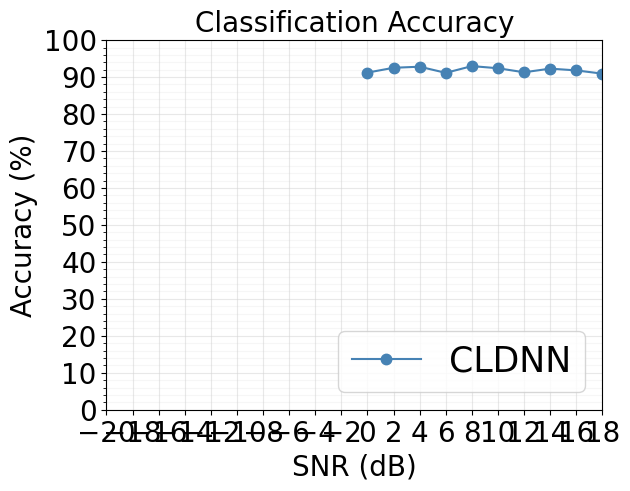

array([0.91210818, 0.92516595, 0.92806602, 0.91143215, 0.92970121,
       0.92391968, 0.91296625, 0.92284507, 0.91807377, 0.90925813])

In [25]:
SNR_accuracy(SNR, 'CLDNN')

In [26]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15,seed=12)
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)
prediction = model.predict([X_test[:,:,:]])
print(X_train.shape)
print(Y_test.shape)
print(X_test.shape)
print(prediction.shape)
Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = [];
for i in range(len(prediction[:,0])):
    Y_Pred.append(np.argmax(prediction[i,:]))
    Y_Test.append(np.argmax(Y_test[i]))

Y_Pred[:20], Y_Test[:20]


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
(77000, 128, 2)
(16500, 11)
(16500, 128, 2)
(16500, 11)


([2, 4, 1, 4, 3, 6, 1, 5, 0, 6, 0, 5, 9, 5, 9, 2, 4, 0, 6, 8],
 [2, 4, 1, 4, 3, 6, 10, 5, 0, 6, 0, 5, 9, 5, 9, 2, 4, 0, 6, 8])


# Visualize activation and feature map

# Plot Confusion Matrix

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', 'confusion matrics', 'README.md', '.gitignore', '.env', 'templates', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git']


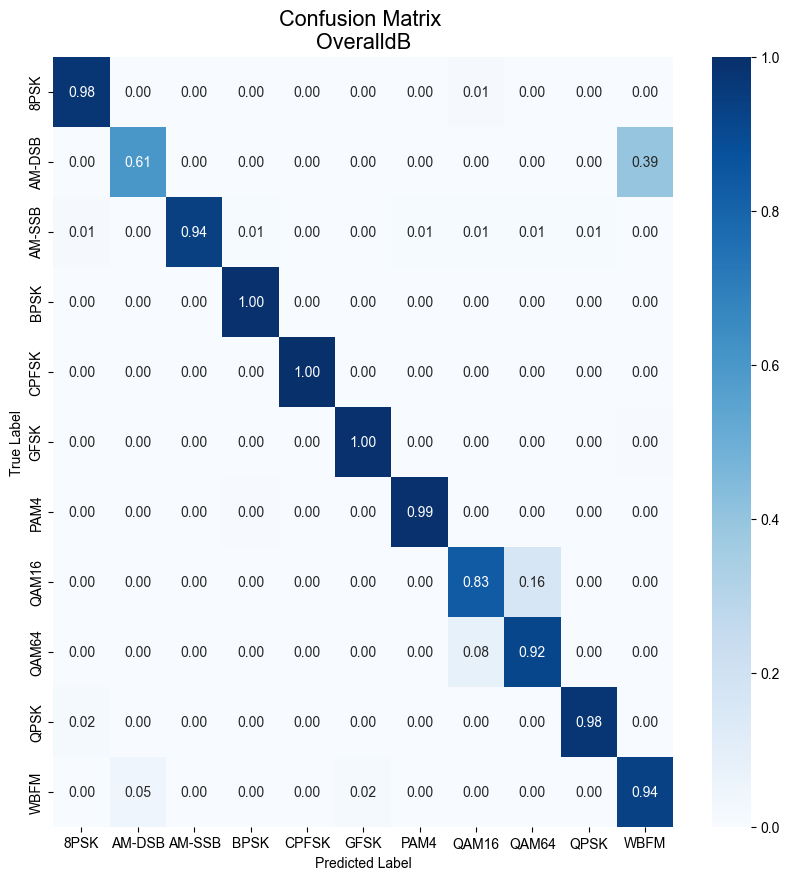

In [27]:
All_SNR_show_confusion_matrix(X_test, save=True)

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', 'confusion matrics', 'README.md', '.gitignore', '.env', 'templates', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git']


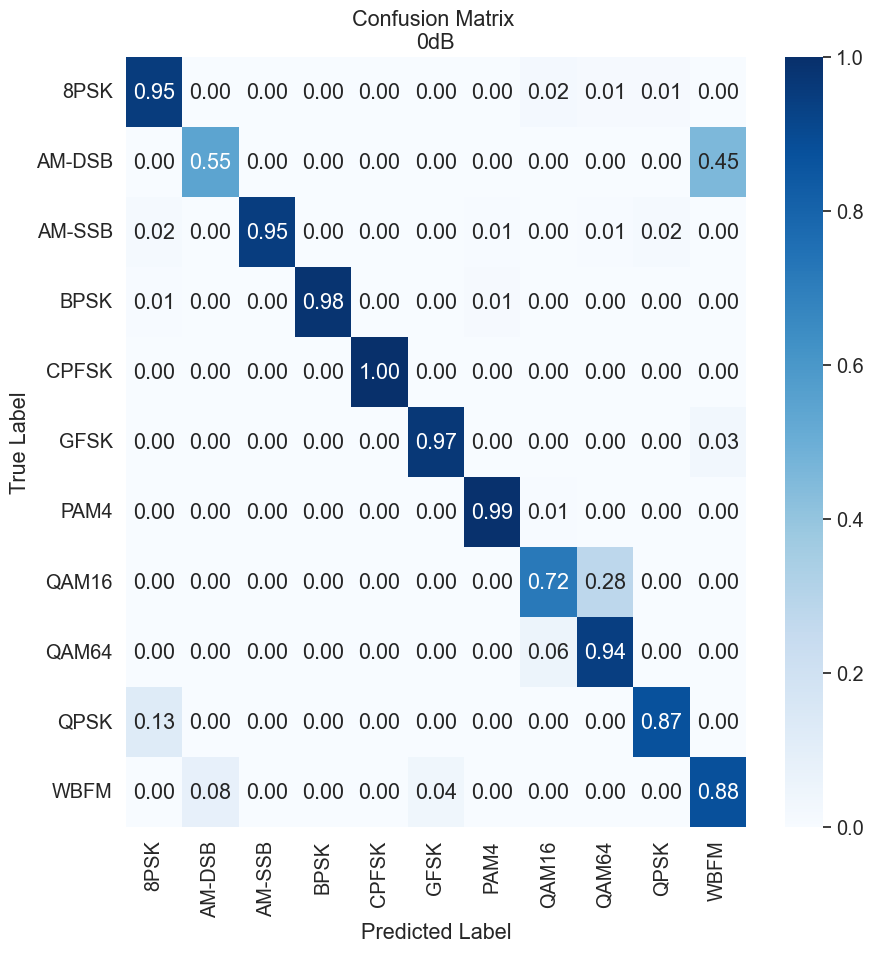

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', 'confusion matrics', 'README.md', '.gitignore', '.env', 'templates', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', '0.png']


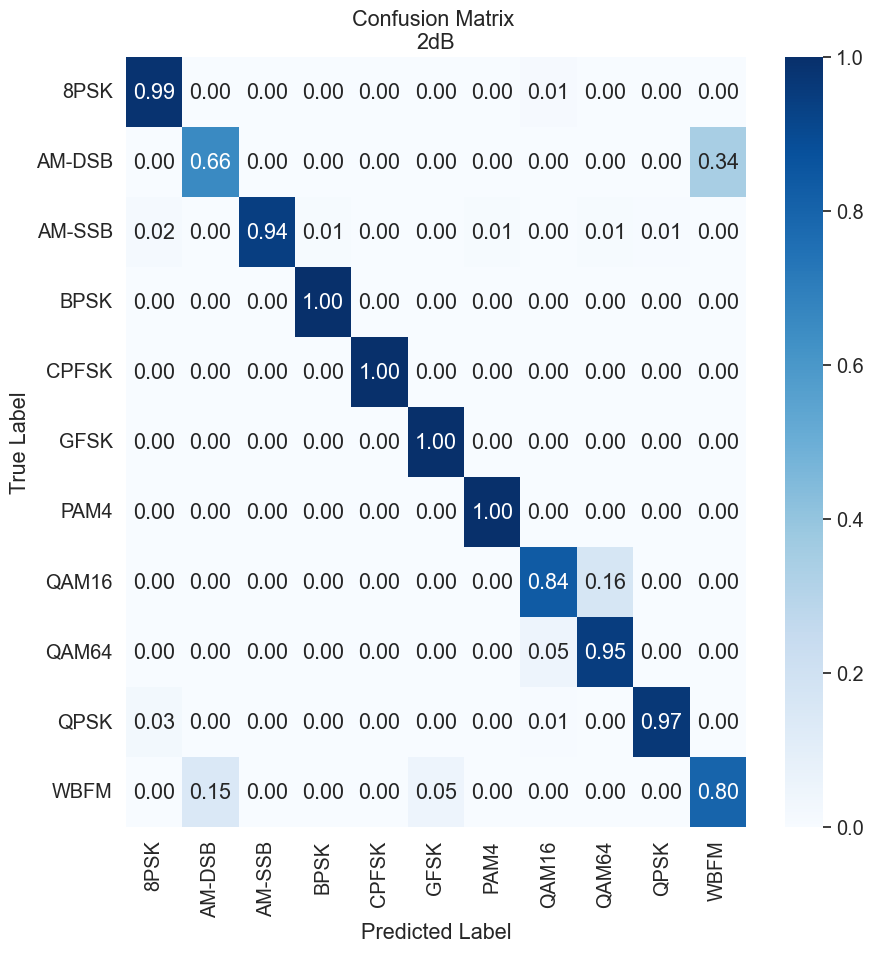

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', 'confusion matrics', 'README.md', '.gitignore', '.env', 'templates', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', '2.png', '0.png']


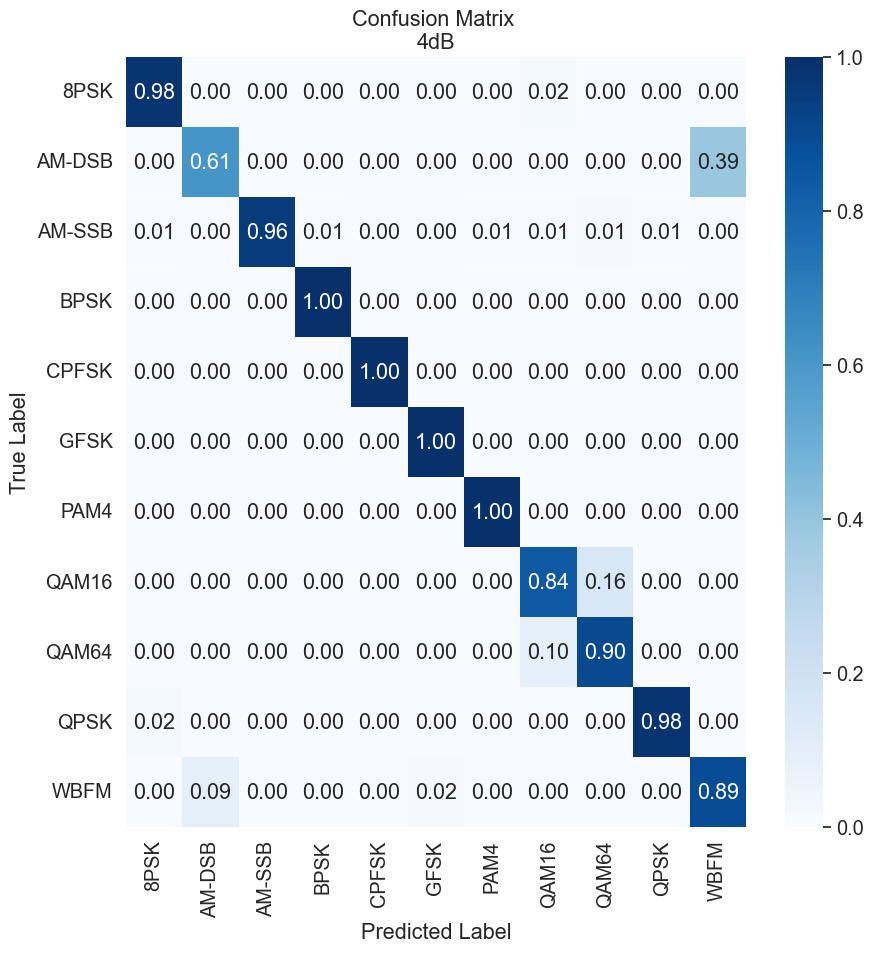

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', 'confusion matrics', 'README.md', '.gitignore', '.env', 'templates', '4.png', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', '2.png', '0.png']


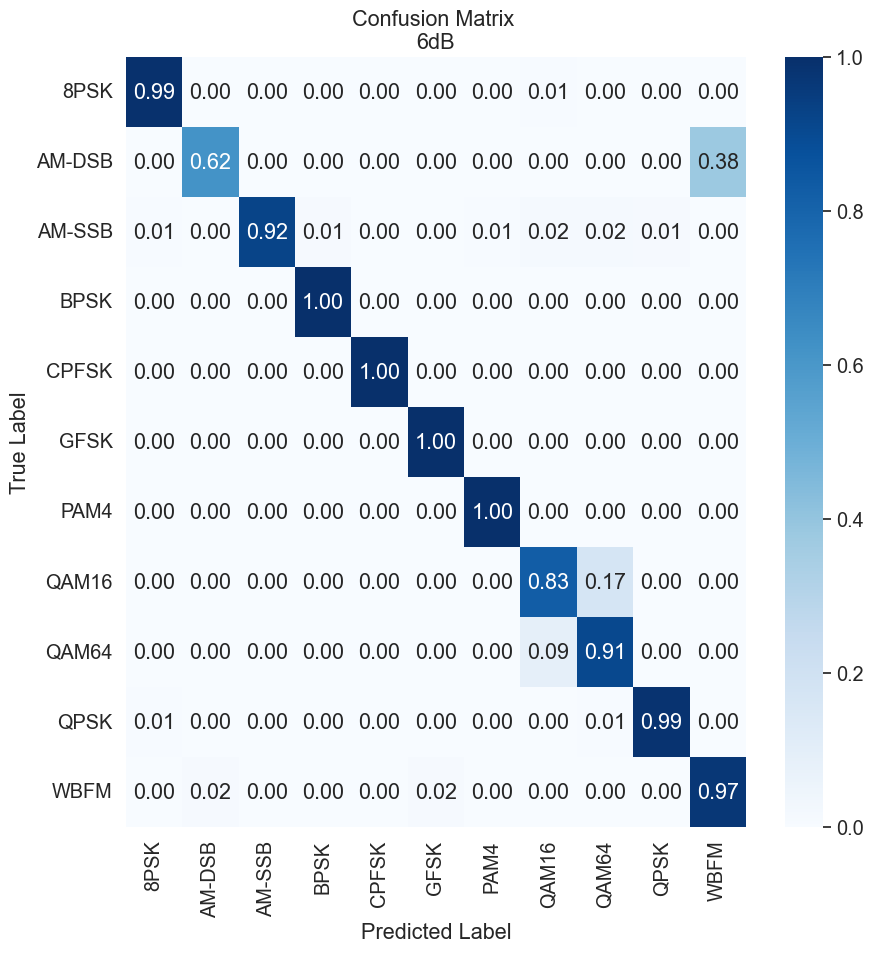

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', 'confusion matrics', 'README.md', '.gitignore', '.env', 'templates', '4.png', 'SNR wise matrices', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', '6.png', '2.png', '0.png']


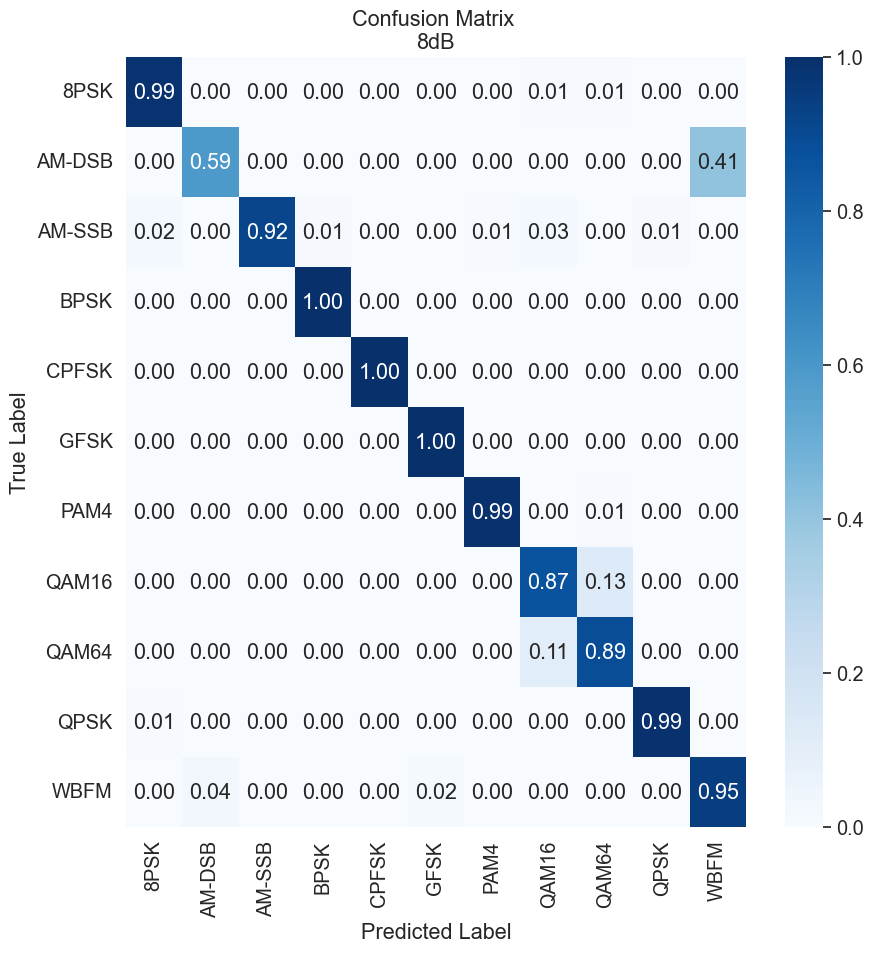

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', '8.png', 'confusion matrics', 'README.md', '.gitignore', '.env', 'templates', '4.png', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', '6.png', '2.png', '0.png']


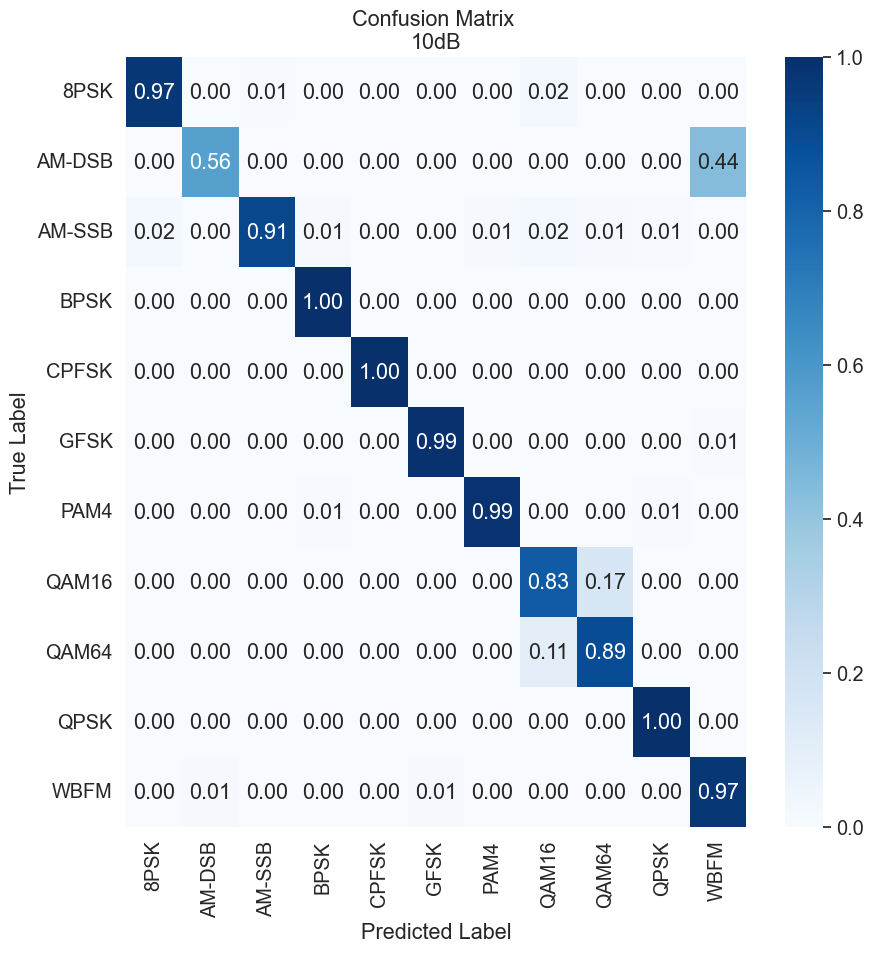

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', '8.png', 'confusion matrics', '10.png', 'README.md', '.gitignore', '.env', 'templates', '4.png', 'SNR wise matrices', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', '6.png', '2.png', '0.png']


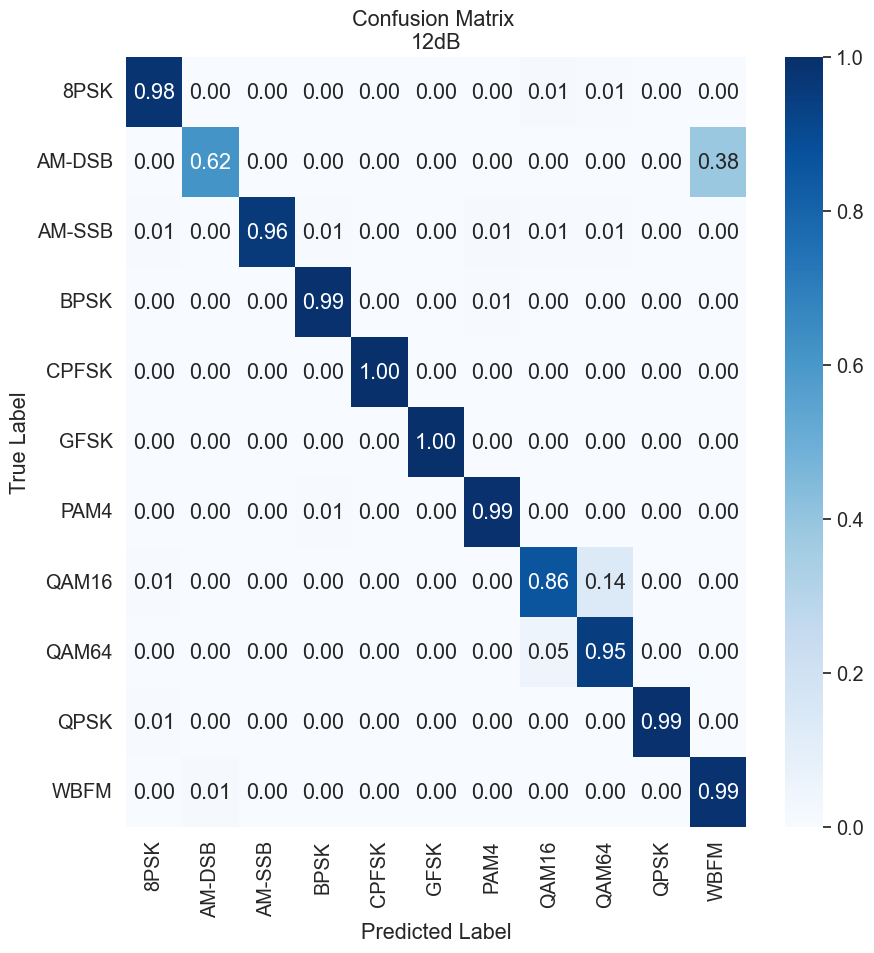

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', '8.png', '12.png', '10.png', 'README.md', '.gitignore', '.env', 'templates', '4.png', 'SNR wise matrices', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', '6.png', '2.png', 'confusion matrices', '0.png']


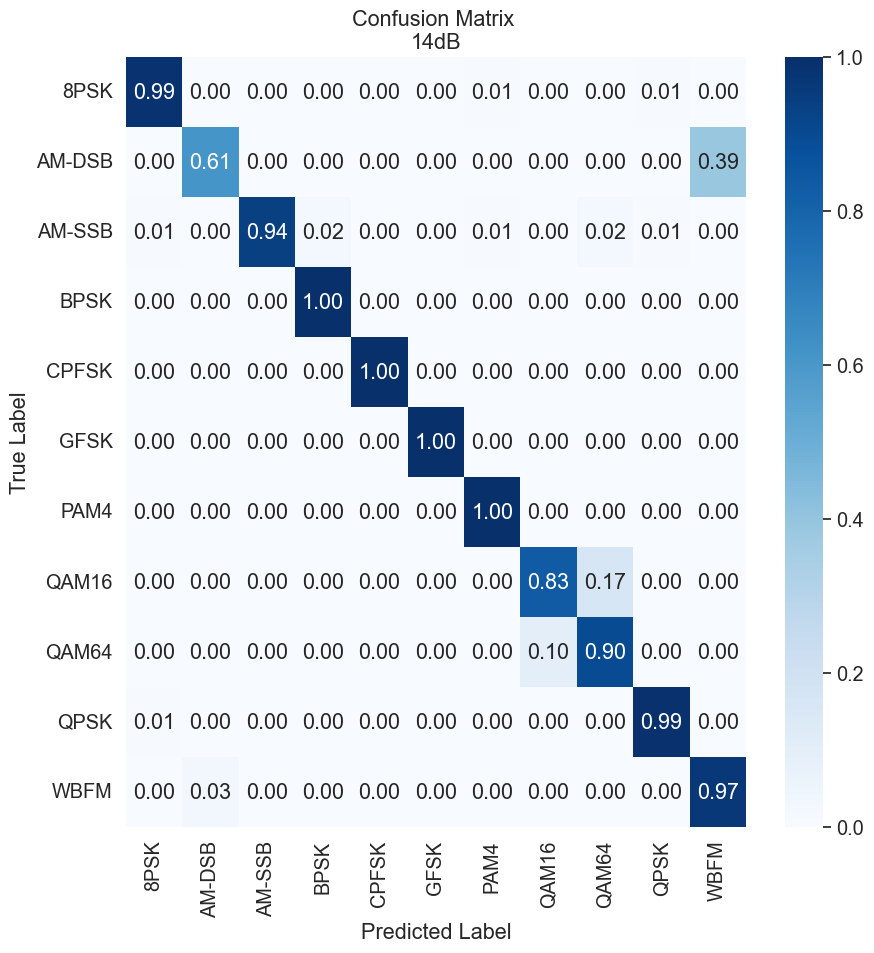

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', '14.png', '12.png', 'README.md', '.gitignore', '.env', 'templates', 'SNR wise matrices', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', 'confusion matrices']


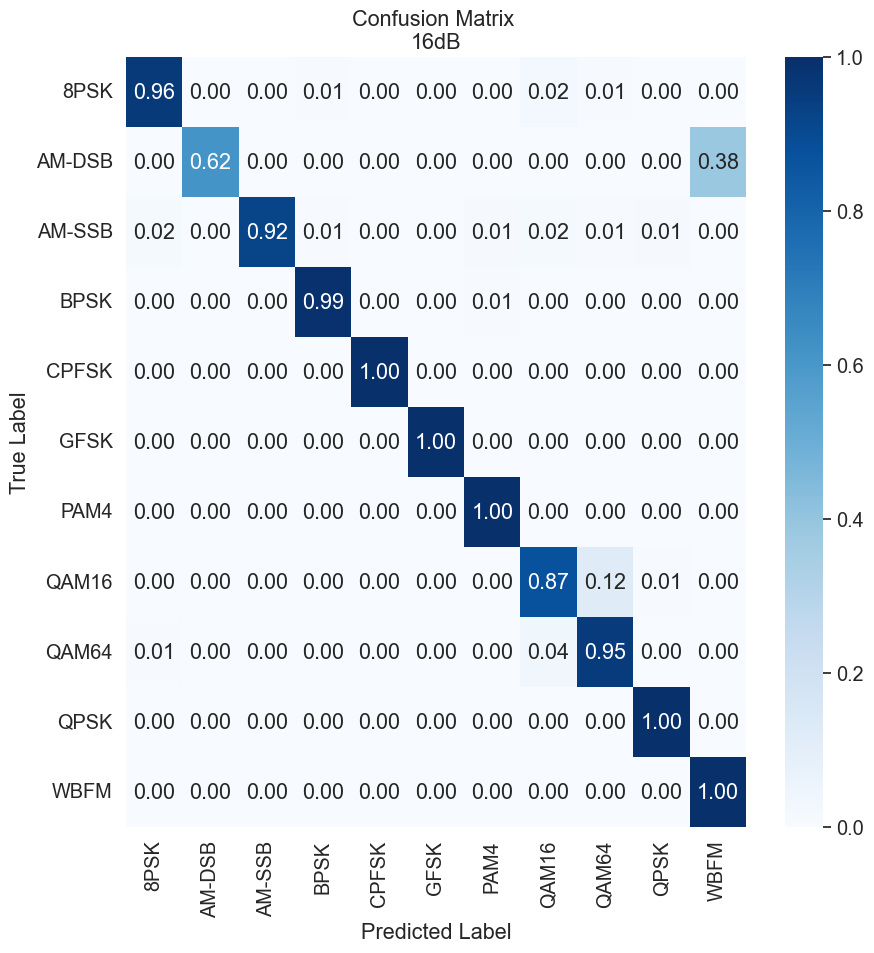

516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
['AMRcode.ipynb', '.DS_Store', 'LICENSE', '14.png', '16.png', '12.png', 'README.md', '.gitignore', '.env', 'templates', 'SNR wise matrices', 'RML2016.10a_dict.pkl', 'cldnn_model_gru.keras', '.git', 'confusion matrices']


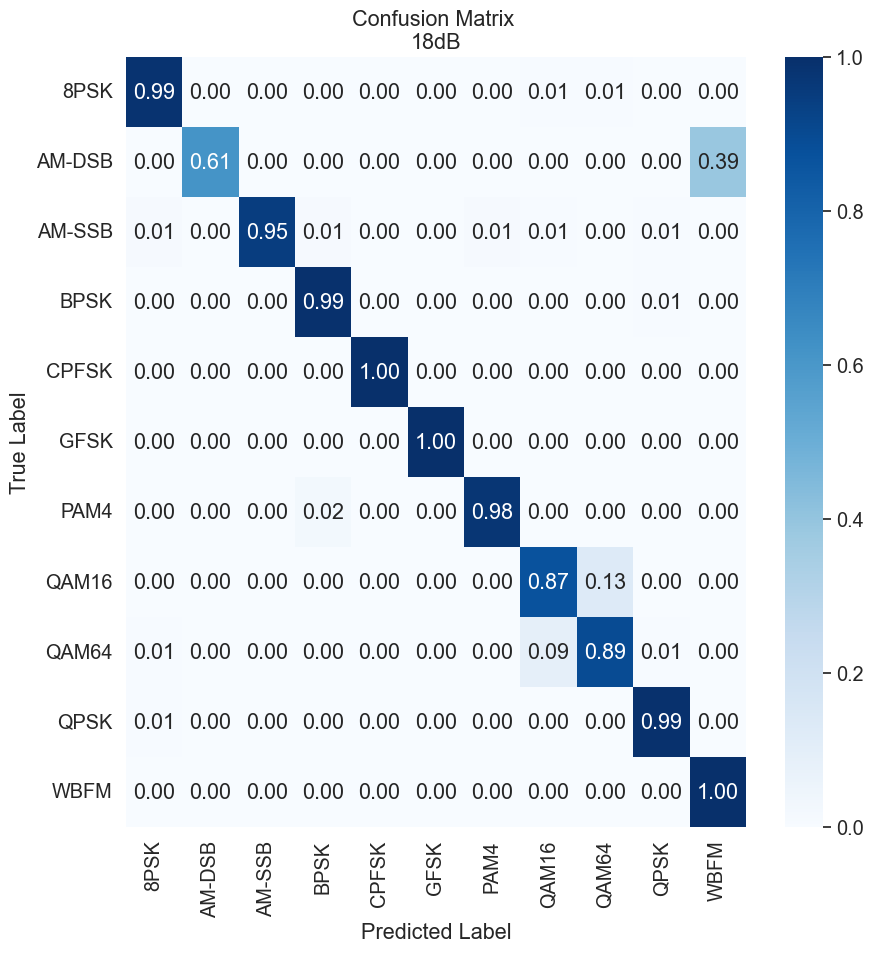

In [30]:
SNR_show_confusion_matrix(range(0,20,2), lbl_SNR[:], X_test, save=True)

## Flask app for FPGA

FPGA will make POST request onto the server running this script, In my case, I will host it on google colab.


In [ ]:

app = Flask(__name__)

@app.route('/')
def home():
    return render_template('predict.html')

@app.route('/predict', methods=['GET', 'POST'])
def predict():
    if request.method == 'GET':
        return render_template('predict.html')

    seed = request.form.get('seed', type=int, default=100)

    print(seed)

    try:
        global flask_x_test
        global flask_y_test
        train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(
            flask_x_test, flask_y_test, train_split=0.7, valid_split=0.15, test_split=0.15, seed=seed
        )
        X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

        prediction = model.predict([X_test[:,:,:]])
        Y_Pred = []
        Y_Test = []

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        pred, test = Y_Pred, Y_Test

        print(pred)
        print(test)

        # SNR_accuracy(SNR, 'CLDNN')

        return render_template('predict.html',
                             seed=seed,
                             pred=pred,
                             test=test,
                             prediction_made=True)

    except Exception as e:
        return render_template('predict.html',
                             error=str(e),
                             prediction_made=True)

def run_app():
    ngrok.set_auth_token = os.environ.get('NGROK_TOKEN')
    public_url = ngrok.connect(5000)
    print(f" * Ngrok tunnel available at: {public_url}")

    app.run(port=5000)

if __name__ == '__main__':
    run_app()